# Imports

In [1]:
import numpy as np
from ase.io import read, write

import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

from ltau_ff.uq_estimator import UQEstimator
from ltau_ff.ase_wrapper import NequIPUQWrapper

# Data loading

In [2]:
pdfs = np.load('../paper_data/per_atom_pdfs_GAP20.npy')
bins = np.load('../paper_data/per_atom_bins_GAP20.npy')

In [3]:
descriptors = np.load('../paper_data/descriptors_GAP20.npy')
descriptors.shape

(360027, 32)

# Prepare estimator

In [4]:
estimator = UQEstimator(
    pdfs,                        # pre-computed, possibly from loss trajectory analysis
    bins,                        # bin edges matching `pdfs`
    descriptors,                 # either static or learned descriptors
    index_type='IndexHNSWFlat',  # FAISS similarity search index
    index_args={              # arguments to be passed to FAISS constructor
        'M': 32,
        'efConstruction': 40,
        'efSearch': 16,
    },
#     index_type='FlatIndexL2',  # another simple (but expensive) index
#     index_args=None,
)

In [5]:
estimator._pdfs.shape

(360027, 100)

In [6]:
estimator._bins.shape

(101,)

# Use estimator with pre-computed descriptors

In [7]:
query_descriptors = np.load('./descriptors_sample_215_GAP20.npy')
query_descriptors.shape

(170, 32)

## To compute the average PDF

In [8]:
query_hist = estimator(query_descriptors, topk=10)
query_hist.shape

(100,)

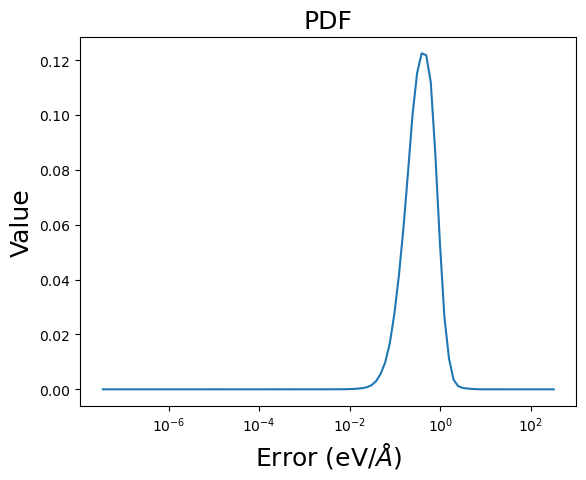

In [9]:
_ = plt.plot(estimator._bins[1:], query_hist)
_ = plt.xscale('log')
_ = plt.xlabel(r'Error (eV/$\AA$)', fontsize=18)
_ = plt.ylabel('Value', fontsize=18)
_ = plt.title('PDF', fontsize=18)

## To evaluate the CDFs for each atom at `atol`

In [10]:
atol = 0.265  # the MAE of this model

In [11]:
pred_u = estimator(query_descriptors, topk=10, atol=atol)
pred_u.shape

(170,)

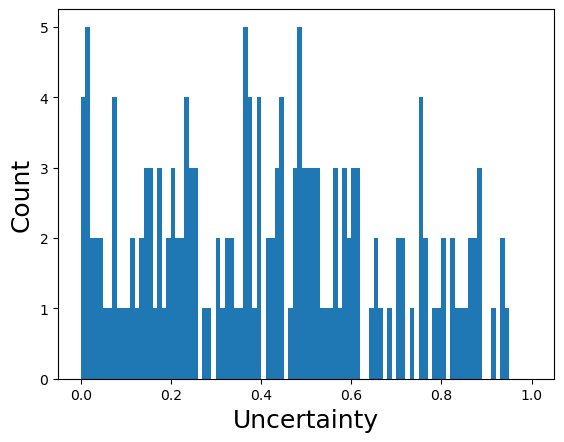

In [12]:
_ = plt.hist(pred_u, bins=np.linspace(0, 1, 101))
_ = plt.xlabel('Uncertainty', fontsize=18)
_ = plt.ylabel('Count', fontsize=18)

# Use estimator within an ASE Wrapper

In [13]:
calc = NequIPUQWrapper.from_deployed_model(
    '../paper_data/deployed_GAP20.pth',
    uq_estimator=estimator
)  # ignore the warnings...

/usr/WS1/vita1/programs/nequip/nequip/utils/_global_options.py:58: UserWarning: Setting the GLOBAL value for jit fusion strategy to `[('DYNAMIC', 3)]` which is different than the previous value of `[('STATIC', 2), ('DYNAMIC', 10)]`
  warnings.warn(
/usr/WS1/vita1/programs/nequip/nequip/ase/nequip_calculator.py:73: UserWarning: Trying to use chemical symbols as NequIP type names; this may not be correct for your model! To avoid this warning, please provide `species_to_type_name` explicitly.
  warnings.warn(


In [14]:
atoms = read('./sample_215_GAP20.extxyz')

calc.calculate(
    atoms,
    properties=['forces'],
    uq=True,
    topk=10,  # number of neighbors over which to estimate the uncertainty,
    atol=atol,
)

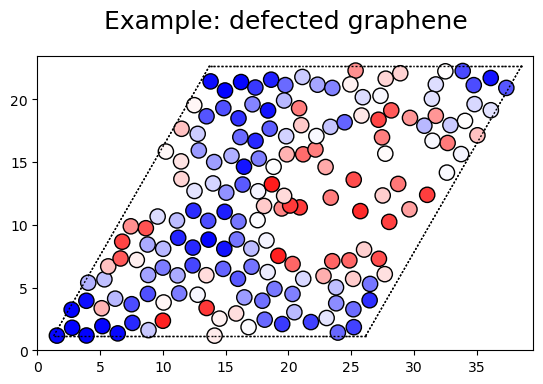

In [15]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('bwr')

_ = plot_atoms(atoms, ax, radii=0.8, colors=cmap(calc.results['uq']))
_ = plt.title('Example: defected graphene', fontsize=18, pad=20)

# Save/load the estimator

In [16]:
estimator.save('./estimator_GAP20.faiss')

In [17]:
estimator = UQEstimator(
    pdfs,  # PDFs can be loaded separately from the indexer
    bins,
#     descriptors,  # descriptors are stored as part of the FAISS indexer
    load_index=True,
    load_path='./estimator_GAP20.faiss'
)

In [18]:
previous_uq = calc.results['uq'].copy()

calc.estimator = estimator
calc.calculate(atoms, properties=['forces'], uq=True, topk=10, atol=atol)

np.linalg.norm(previous_uq - calc.results['uq'])  # making sure they're the same as before

0.0

# Helper functions

In [19]:
from ltau_ff.utils import logs_to_pdfs

In [20]:
help(logs_to_pdfs)

Help on function logs_to_pdfs in module ltau_ff.utils:

logs_to_pdfs(logs, bins, nbins=None, range_limits=None, bin_spacing='log')
    Computes the PDF of errors for each sample using an ensemble of error trajectories.
    Modified from SO post:
    
    https://stackoverflow.com/questions/44152436/calculate-histograms-along-axis
    
    Args:        
        logs (list[np.ndarray]): a list of M arrays, where each element in the
            list is of size (T_m, N). T_m is the number of training epochs for
            the m-th model in the ensemble.
            
        bins (np.ndarray): array of bin edges. If not provided, must provide
        `nbins`, `range_limits`, and `bin_spacing`.
    
        nbins (int): the number of bins to use for computing the PDFs
        
        range_limits (tuple[float]): the upper/lower limits of the bins. If not
        provided, uses the min/max error from `logs`.
        
        bin_spacing (str): one of "log" or "linear". Default is "log".

